# Data processing for global correlation wavefield

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/tsonpham/ObsSeisHUS2025/blob/master/Day4/D4_Prac.ipynb)

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), April 2025

---
## What we do in this notebook


In [23]:
# Environemtal setup (uncomment if running in colab)

!pip install obspy numpy==1.26.3

In [24]:
#@title Notebook visualisation settings

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Data preparation and preprocessing

In [25]:
#@title Data preparation
#@markdown Helper function to download and process seismic data from IRIS

from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from pathlib import Path
from obspy import read_events, read_inventory, read
from obspy.geodetics import locations2degrees
import pickle

def get_event(isc_eventid):
    """
    Get the origin time of an event given its event ID.
    """
    # file name for the event information
    fname = Path(f'ISC.{isc_eventid}.xml')
    # Download the event information from ISC if not already downloaded
    if not fname.exists():
        event = Client('ISC').get_events(eventid=isc_eventid, filename=fname)
    # Read the event information from the file
    event = read_events(fname)[0]
    return event

def get_waveform_data(event_origin, network='_GSN', channel='LHZ', window_start=10e3, window_end=35e3,
        loc_priorities = ['', '00', '10']):

    eventtime = event_origin.time
    evla = event_origin.latitude
    evlo = event_origin.longitude
    # Fearch for all stations in the _GNS network recording in the time window
    inv_fname = Path(network+eventtime.strftime('.%Y%m%d.staxml'))
    # Download the station information from IRIS unless already downloaded
    if not inv_fname.exists():
        Client().get_stations(network=network, channel=channel, starttime=eventtime,
                              endtime=eventtime+24*3600, level='channel', filename=inv_fname)
    # Read the station information from the file
    inv = read_inventory(inv_fname)

    # For each station, add a line to the bulk request depending on their location code
    # and the location code with the highest priority
    # The location codes are sorted by priority
    bulk = []
    for net in inv:
        for sta in net:
            loc_codes = [cha.location_code for cha in sta.channels]
            if len(set(loc_priorities) & set(loc_codes)) == 0: continue
            # get the location code with the highest priority
            for loccode in loc_priorities:
                if loccode in loc_codes: break
            # add the bulk entry
            bulk.append((net.code, sta.code, loccode, channel,
                # the time window is padded by 2,500 seconds at both ends to for quality assurance
                eventtime+window_start-2.5e3, eventtime+window_end+2.5e3))

    # Download the waveforms from IRIS if not already downloaded
    pkl_fname = Path(network+eventtime.strftime('.%Y%m%d.pkl'))
    if not pkl_fname.exists():
        print (f'Requesting waveforms for {len(bulk)} individual {channel} channels ...')
        dstream = Client().get_waveforms_bulk(bulk, longestonly=True, minimumlength=7*3600)
        # Append metadata to header
        for tr in dstream:
            tmp = inv.select(network=tr.stats.network, station=tr.stats.station)[0][0]
            tr.stats.update({'stla': tmp.latitude, 'stlo': tmp.longitude,
                'distance': locations2degrees(evla, evlo, tmp.latitude, tmp.longitude)*111.195e3})
        with open(pkl_fname, 'wb') as f: pickle.dump(dstream, f)
    else:
        # print ('Reading waveforms ...')
        with open(pkl_fname, 'rb') as f: dstream = pickle.load(f)
    return dstream

def data_processing(dstream, channel, evtime, window_start, window_end):
    dstream1 = dstream.copy()
    if channel != 'LHZ': dstream1.resample(1.0)
    dstream1.detrend('linear')
    dstream1.taper(max_percentage=0.01, type='cosine')
    dstream1.trim(evtime+window_start, evtime+window_end, pad=True, fill_value=0)
    return dstream1

We call the function below to download vertical waveform data from all stations part of the global seismograph network.

In [26]:
# Specify the event ID, network, channel, and time window
isc_eventid = '611831635'
network = '_GSN'
channel = 'LHZ'
window_start = 10e3
window_end = 35e3
sampling_rate = 1.0 # Hz by default because we are using LHZ
npts = int((window_end-window_start)/sampling_rate) # number of samples in the time window

# fetch event metadata using ISC event ID,
event = get_event(isc_eventid)
# download the waveforms from IRIS unless they existed locally
dstream = get_waveform_data(event.preferred_origin(), network, channel, window_start, window_end)
# do some simple data processing: trim the waveform at desired time window and resample 1 Hz
dstream = data_processing(dstream, channel, event.preferred_origin().time, window_start, window_end)

Simple data processing

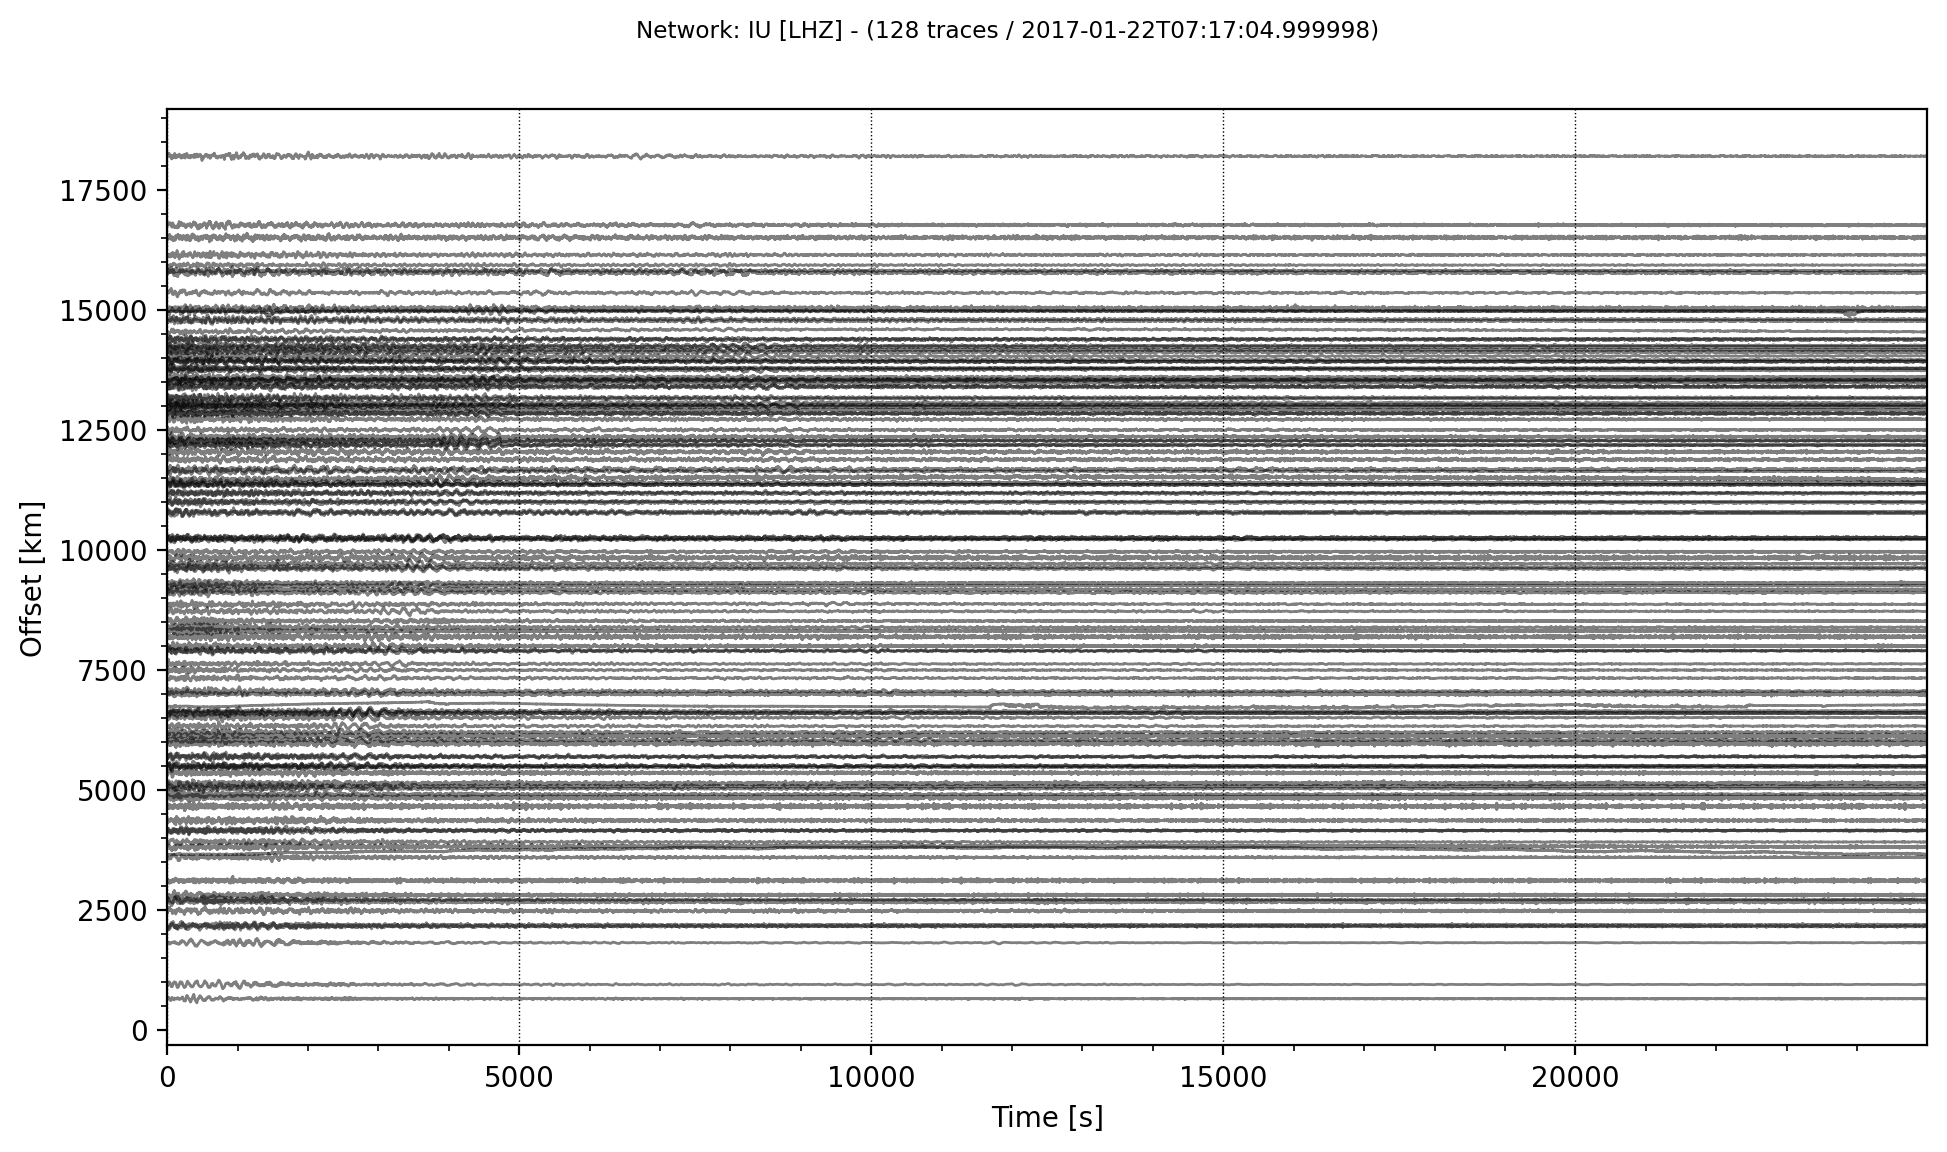

In [27]:
import matplotlib.pyplot as plt
dstream.plot(type='section', orientation='horizontal', color='black', show=True)
plt.show()

---
## Single station processing

- Temporal normalization

- Spectral normalization

Here we demonstrate how the running absolute mean normalization work in the time domain.

In [28]:
from obspy import Trace, Stream
import numpy as np

def running_absolute_mean_normalization(input_tr, width, filter_kw=None):
    """
    Apply running absolute mean normalization to a waveform/spectral trace.
    :param trace: ObsPy Trace object
    :param fband: frequency band for the filter / None if no pre-filtering is applied to the weight
    :param width: width of the running absolute mean normalization window in seconds or Hz depending on the input_tr
    :return: output_tr trace
    """
    if type(input_tr) is not Trace:
        raise TypeError('Input trace is not an ObsPy Trace object.')
    # pre-filter the weight trace if frequency filter band is given
    weight_tr = input_tr.copy()
    output_tr = input_tr.copy()
    if type(input_tr.data[0]) is np.complex128 or type(input_tr.data[0]) is np.complex64:
        delta = input_tr.stats.delta_f
    else:
        delta = input_tr.stats.delta
    # if pre-filtering is indicated, apply the filter to the weight trace
    if filter_kw is not None: weight_tr.filter(**filter_kw)
    # calculate the normalizing weight by running absolute mean
    winlen = 2 * int(0.5 * width / delta) + 1
    avg_mask = np.ones(winlen) / winlen
    weight = np.convolve(np.abs(weight_tr.data), avg_mask, 'same')
    # divide the orignal data by the smoothed weight
    mask = (weight > 1e-8*np.max(weight))
    output_tr.data[mask] = input_tr.data[mask] / weight[mask]
    output_tr.data[np.logical_not(mask)] = 0
    # return the output_tr trace
    return output_tr

We demonstrate the running absolute mean normalization in the temoporal domain.

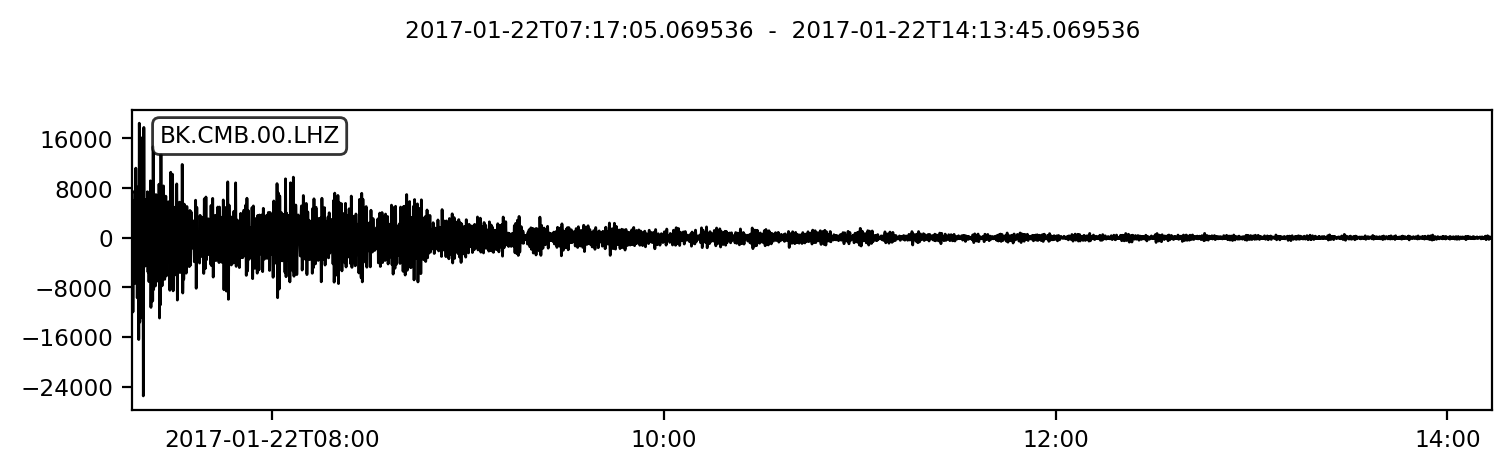

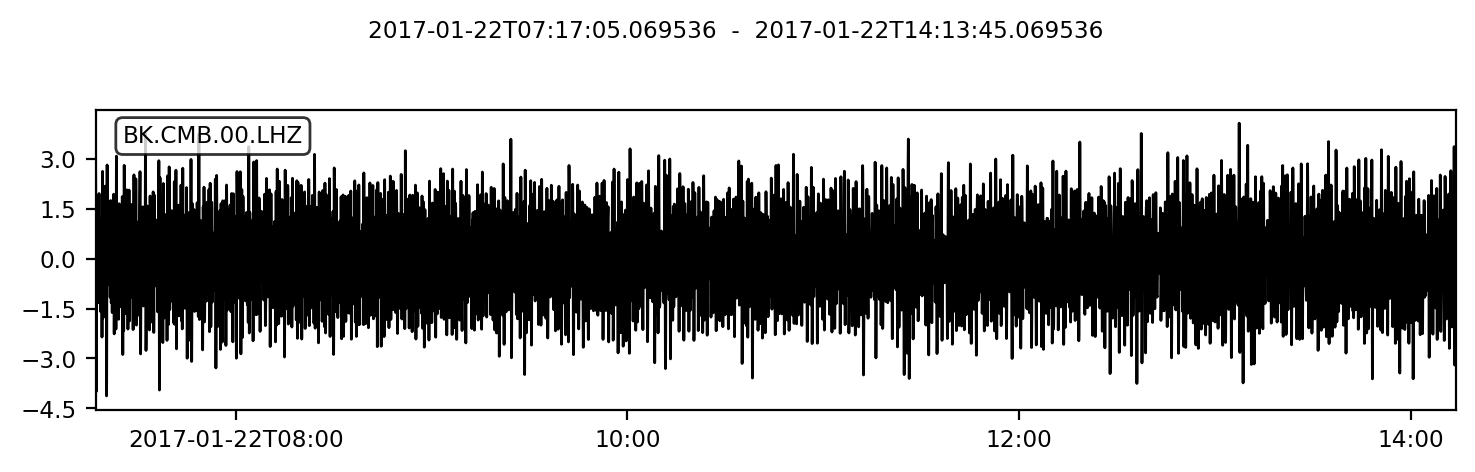

In [29]:
# Specify temporal normalization parameters
temp_width = 128 #seconds
filter_kw = dict(type='bandpass', freqmin=0.02, freqmax=0.067, corners=4, zerophase=True) # bandpass filter between 15 to 50 seconds

# Apply running absolute mean normalization to the data
input_tr = dstream[0].copy() # an example trace
tmp = input_tr.copy().filter(**filter_kw)
tmp.plot()

output_tr = running_absolute_mean_normalization(input_tr, temp_width, filter_kw)
tmp = output_tr.copy().filter(**filter_kw)
tmp.plot()

plt.show()

We also use the running absolute mean function for spectral normalization.

In [30]:
from scipy.fftpack import next_fast_len
def spectral_normalization(input_tr, npts, ram_width):
    """
    Apply spectral normalization to a waveform trace.
    :param input_tr: ObsPy Trace object
    :param npts: number of points for FFT
    :param ram_width: width of the running absolute mean normalization window in seconds
    :return: output_tr trace
    """
    # get the number of points for FFT using tensorflow fft module
    fft_npts = next_fast_len(2*npts)
    # real-to-complex FFT by numpy
    spec_data = np.fft.rfft(input_tr.data, fft_npts)
    # create a spectral trace
    spec_tr = Trace(data=spec_data, header=input_tr.stats)
    spec_tr.stats.update({'npts':len(spec_data), 'delta_f':.5/((len(spec_data)-1)*input_tr.stats.delta)})
    # apply running absolute mean normalization to the spectral trace
    if ram_width is not None:
        return running_absolute_mean_normalization(spec_tr, ram_width)
    else:
        return spec_tr

Here we demonstrate the spectral normalization (whitening) for a pilot waveform

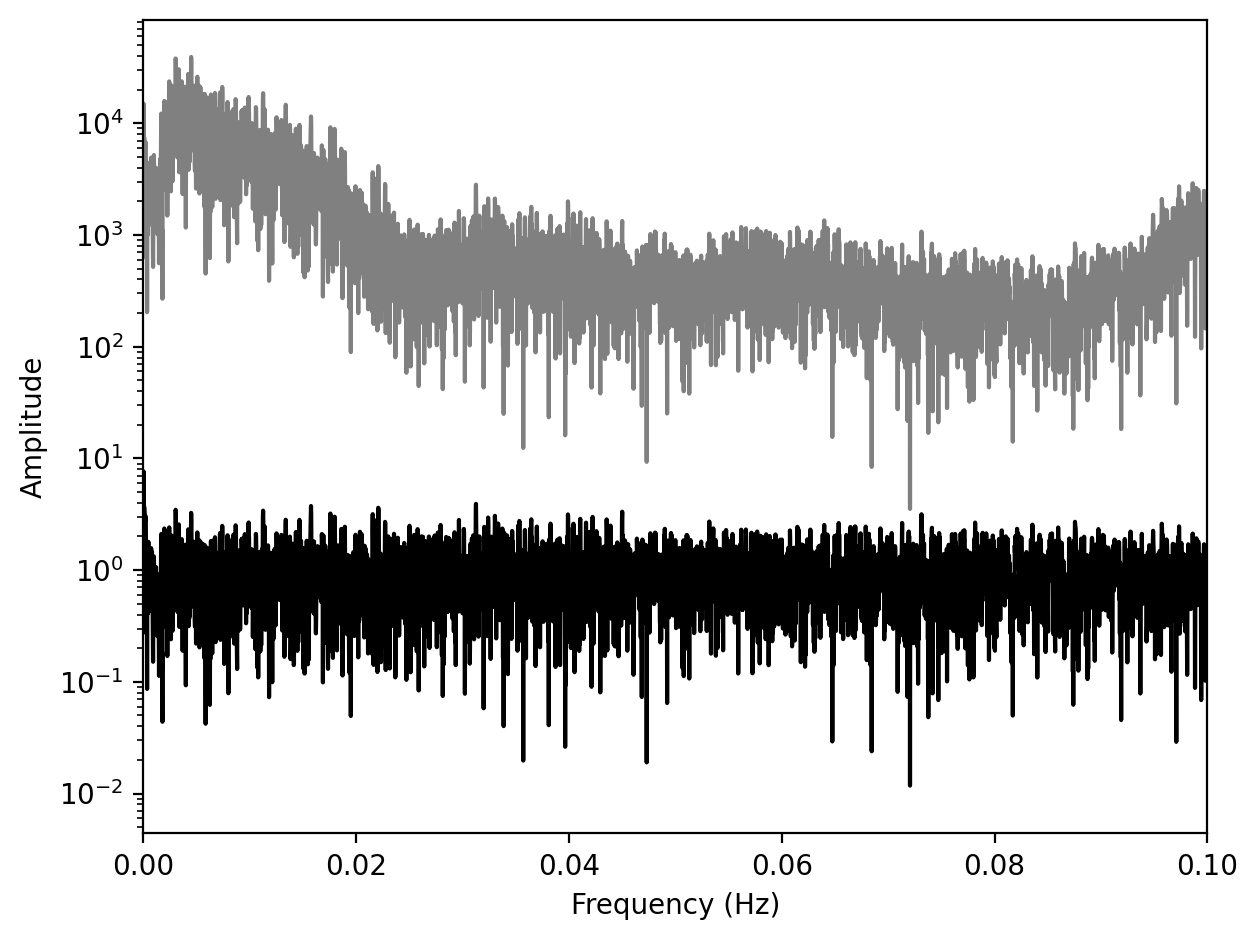

In [31]:
# Specify spectral normalization parameters
spec_width = 2e-3 # Hz

# apply spectral normalization to the data
spec_tr = spectral_normalization(output_tr, npts, spec_width)
# when spec_width is None, the plain spectrum of the input trace is returned for comparison
spec_tr0 = spectral_normalization(output_tr, npts, None)

fig, ax = plt.subplots()
freqs = np.arange(spec_tr.stats.npts) * spec_tr.stats.delta_f
ax.semilogy(freqs, np.abs(spec_tr.data), color='black')
ax.semilogy(freqs, np.abs(spec_tr0.data), color='gray')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_xlim([0, 0.1])
fig.tight_layout()
plt.show()

Let's see the effect of each processing step on a single waveforms

In [32]:
def single_station_processing(dstream):
    spec_st = Stream()
    for data_tr in dstream:
        temp_tr = running_absolute_mean_normalization(data_tr, temp_width, filter_kw)
        spec_tr = spectral_normalization(temp_tr, npts, spec_width)
        spec_st.append(spec_tr)
    return spec_st

In [33]:
print ('Parameterisation used in the single-station processing:')
print (f' Waveform channel: {channel}')
print (f'       Event time: {event.preferred_origin().time}')
print (f'       Window start: {event.preferred_origin().time+window_start}')
print (f'       Window end: {event.preferred_origin().time+window_end}')
print (f'       Sampling rate: {sampling_rate} Hz')
print ('  Temporal normalization: running absolute mean normalization')
print (f'       Temporal width: {temp_width} seconds')
print (f'       Weight filtering band: {filter_kw["freqmin"]} to {filter_kw["freqmax"]} Hz')
print ('  Spectral normalization: running absolute mean normalization')
print (f'       Spectral width: {spec_width} Hz')
print (f'       Number of points: {npts}')

import time
start = time.time()
spec_st = single_station_processing(dstream)
print (f'\nSingle processing of {len(dstream)} traces took {time.time()-start:.2f} seconds')

Parameterisation used in the single-station processing:
 Waveform channel: LHZ
       Event time: 2017-01-22T04:30:24.610000Z
       Window start: 2017-01-22T07:17:04.610000Z
       Window end: 2017-01-22T14:13:44.610000Z
       Sampling rate: 1.0 Hz
  Temporal normalization: running absolute mean normalization
       Temporal width: 128 seconds
       Weight filtering band: 0.02 to 0.067 Hz
  Spectral normalization: running absolute mean normalization
       Spectral width: 0.002 Hz
       Number of points: 25000

Single processing of 128 traces took 0.83 seconds


---
## Station pair cross-correlation

We use the spectral data obtained from this step to perform cross-correlation. It involve the multiplication of one spectra to the conjugate of the others.

As the number of operation is O (N^2), increase as squared of cross-correlation function. The cell below show the principle of this processing step, which is optimized later to run in many station.

In [34]:
from obspy.geodetics import locations2degrees
from concurrent.futures import ThreadPoolExecutor
import threading

def xcorr_stack(spec_st, dist_bins, max_tlag, ncores=2, fname=None):
    '''
    Calculates the cross-correlation function of the given spectral data. Run the jobs
    on a GPU device if available, otherwise, run on CPU using threading.

    Args:
        spec_data (ndarray): The spectral data, represented as a complex numpy array.
        nbins (int): The number of cross-correlation distance bins.
        cc_inds (ndarray): The indices of the cross-correlation bins.

    Returns:
        ndarray: The cross-correlation function in the time domain.
    '''
    stlats = [tr.stats.stla for tr in spec_st]
    stlons = [tr.stats.stlo for tr in spec_st]
    spec_data = np.array([tr.data for tr in spec_st])
    # number of traces and frequency bins
    ntraces, nspec = spec_data.shape
    # number of cross-correlation distance bins
    nbins = len(dist_bins) - 1
    # global variables
    spec_xcorr_stack = np.zeros([nbins, nspec], dtype=np.complex128)
    bin_count = np.zeros(nbins, dtype=np.float32)

    # calculate all inter-receiver distances
    mlats, mlons = np.meshgrid(stlats, stlons)
    cc_gcarc = locations2degrees(mlats, mlons, mlats.T, mlons.T)
    # determine the bin index for each inter-receiver distance
    cc_inds = np.digitize(cc_gcarc, dist_bins) - 1

    # Create a lock for each bin
    # Note: the multiple locks for each bin is recommended to avoid congested
    # memory access when multiple threads are trying to access the same bin.
    locks = [threading.Lock() for _ in range(nbins)]

    # Create a ThreadPoolExecutor
    with ThreadPoolExecutor(ncores) as executor:
        # Local cross-correlation function to excecuted in multiple threads
        def cross_correlation(s1):
            # Cross-correlation function in frequency domain
            spec_xcorr = spec_data[s1] * np.conj(spec_data[s1:])
            for _, ind in enumerate(cc_inds[s1, s1:]):
                # Acquire the lock for stacking
                with locks[ind]:
                    # Bin pair cross-correlograms in frequency domain
                    spec_xcorr_stack[ind] += spec_xcorr[_]
                    # Count the trace pairs in each inter-receiver bin
                    bin_count[ind] += 1

        # Run the cross-correlation function in a separate thread
        for s1 in range(ntraces):
            executor.submit(cross_correlation, s1)

    # inverse FFT to get the cross-correlation function in time domain
    correlogram = np.fft.irfft(spec_xcorr_stack)
    # fold the cross-correlation function and trim the time window
    nmaxlag = int(max_tlag / spec_st[0].stats.delta)
    correlogram = 0.5 * (correlogram + correlogram[:, ::-1])[:, :nmaxlag]

    # output in dictionary
    output = dict(bin_count=bin_count, # number of traces in each bin
                  delta_t=spec_st[0].stats.delta, # seconds
                  delta_d=dist_bins[1] - dist_bins[0], # degrees
                  interstation_dist=(dist_bins[1:]+dist_bins[:-1])/2, # seconds
                  time_lapse=np.arange(nmaxlag)*spec_st[0].stats.delta, # degrees
                  correlogram=correlogram) # dimensionaless of size (nbins, nmaxlag)
    # save the output to a file if fname is given
    if fname is not None:
        with open(fname, 'wb') as f: pickle.dump(output, f)
    return output

In [35]:
dist_bins = np.linspace(0, 180, 181) # degrees
max_tlag = 7000 # seconds
output = xcorr_stack(spec_st, dist_bins, max_tlag)

We define the following function to plot the correlograms

In [36]:
def plot_correlogram(correlogram_or_fname, filter_kw, ymax=4000, title=None):
    """
    Plot the cross-correlation function and the number of traces in each bin.
    """
    if type(correlogram_or_fname) is not dict:
        with open(correlogram_or_fname, 'rb') as f: correlogram = pickle.load(f)
    else:
        from copy import deepcopy
        correlogram = deepcopy(correlogram_or_fname)

    # Get info from the correlogram dictionary
    delta = correlogram['delta_t']
    bin_count = correlogram['bin_count']
    img = correlogram['correlogram']
    time_lapse = correlogram['time_lapse']
    inter_dist = correlogram['interstation_dist']

    # Normalize the cross-correlation function by the number of traces in each bin
    from obspy.signal.filter import bandpass
    for i in range(img.shape[0]):
        if bin_count[i] == 0: continue
        img[i] = bandpass(img[i], df=1/delta, freqmin=filter_kw['freqmin'], freqmax=filter_kw['freqmax'],
                            corners=filter_kw['corners'], zerophase=filter_kw['zerophase'])
        img[i] /= bin_count[i]

    # Plot the cross-correlation function
    fig, ax = plt.subplots(2, 1, figsize=(3.5, 7), sharex=True, gridspec_kw={'height_ratios': (.2, 1.)})
    ax[0].bar(np.arange(len(bin_count)), bin_count, width=1, color='gray', edgecolor='none')
    ax[0].set(ylabel='# pairs', title=title)

    VMAX = 2.5e-2 * np.max(np.abs(img))
    ax[1].imshow(img.T, aspect='auto', vmin=-VMAX, vmax=VMAX, cmap='seismic', origin='lower',
                interpolation='sinc', extent=(0, 180, time_lapse[0], time_lapse[-1]))

    ax[1].set(ylim=(0, ymax), xlim=(0, 180),
            xlabel='Inter-station distance (degrees)', ylabel='Time lag (seconds)')
    for x in ax: x.grid(ls='--', lw=.5, color='gray')
    fig.tight_layout()
    plt.show()

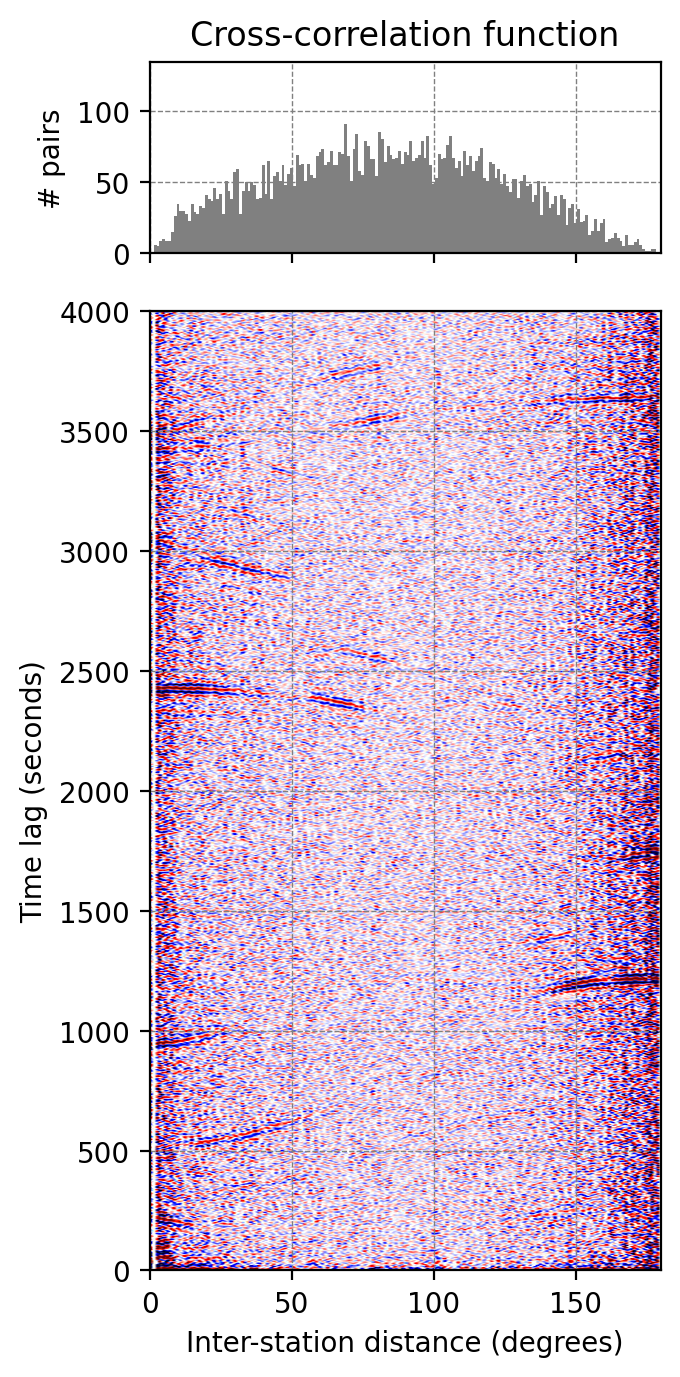

In [37]:
plot_correlogram(output, filter_kw, title='Cross-correlation function')

---
## Challenge

Now, would you mind to run the processing for a different event and see how they look. Please upload your GSN.??????.XCORR.h5 to Google Drive [here](https://drive.google.com/drive/folders/1lb2l7j_LEF_F-NTgOeb-7HqKTeNYYOkD?usp=sharing). We will see how the global correlogram stacked by multiple look like.

In [ ]:
## Enter your code here

In [ ]:
# import pandas as pd
# df = pd.read_csv('GradeA_events.csv')
# df

isc_eventid        date  latitude  longitude  depth  magintude  \
0      14686988  2010-05-09      3.69      96.04   41.0       7.27   
1     600191591  2010-12-21     26.88     143.78   20.0       7.50   
2     600800706  2012-03-20     16.47     -98.37   19.0       7.63   
3     601675877  2012-09-05     10.02     -85.39   21.0       7.73   
4     601768557  2012-09-30      1.91     -76.37  155.0       6.84   
5     607727143  2014-04-01    -19.96     -71.02   11.0       6.25   
6     610573069  2014-10-14     12.59     -88.07   64.0       6.58   
7     612180979  2015-10-26     36.50      70.53  204.0       7.15   
8     608079035  2015-12-04    -47.68      85.31   26.0       6.82   
9     615035032  2016-11-13    -42.67     172.92   16.0       8.03   
10    609939179  2016-12-25    -43.42     -73.92   34.0       7.71   
11    611831635  2017-01-22     -6.23     155.07  157.0       7.15   

   magnitude_type                               region  
0              MS                    Northern Sumatera  
1              MS                 Bonin Islands region  
2              MS               Near coast of Guerrero  
3              MS                           Costa Rica  
4              mb                             Colombia  
5              mb          Off coast of northern Chile  
6              mb         Off coast of central America  
7              mb                    Hindu Kush region  
8              MS               Southeast Indian Ridge  
9              MS                         South Island  
10             MS                       Southern Chile  
11             mb  Bougainville-Solomon Islands region

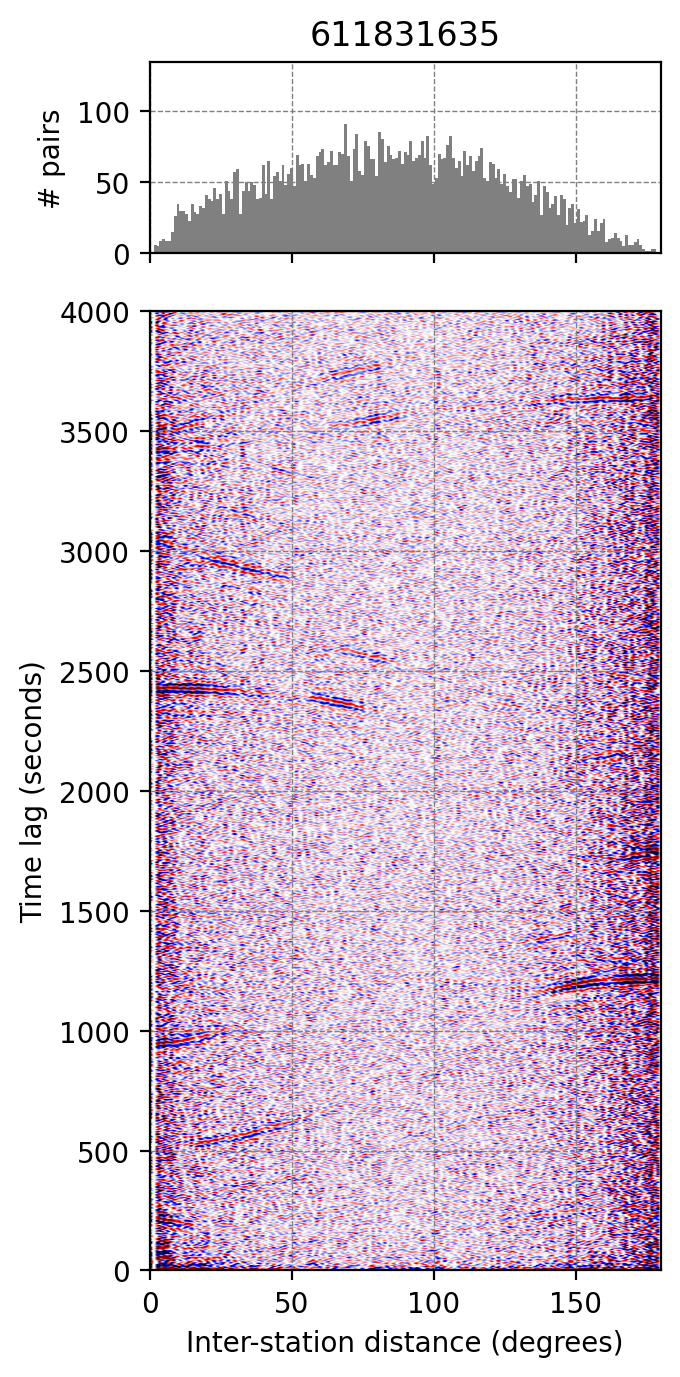

In [ ]:
#@title View the solution

isc_eventid = "611831635"

# Fetch the event information
event = get_event(isc_eventid)

# Download the waveforms from IRIS unless they existed locally
dstream = get_waveform_data(event.preferred_origin(), network, channel, window_start, window_end)

# Do some simple data processing: trim the waveform at desired time window and resample 1 Hz
dstream = data_processing(dstream, channel, event.preferred_origin().time, window_start, window_end)

# Process single station data
spec_st = single_station_processing(dstream)

# Specify cross-correlation parameters
corr_fname = event.preferred_origin().time.strftime(f'XC.%Y%m%d.npy')
xcorr_stack(spec_st, dist_bins, max_tlag, fname=corr_fname)

# Plot the cross-correlation function
plot_correlogram(corr_fname, filter_kw, title=isc_eventid)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# for isc_eventid in df['isc_eventid']:
#     # Fetch the event information
#     event = get_event(isc_eventid)
#     corr_fname = event.preferred_origin().time.strftime(f'XCORR/XC.%Y%m%d.npy')
#     if Path(corr_fname).exists():
#         print (f'File {corr_fname} already exists. Skipping ...')
#         continue
#     print (f'Processing event {isc_eventid} ...')

#     # Download the waveforms from IRIS unless they existed locally
#     dstream = get_waveform_data(event.preferred_origin(), network, channel, window_start, window_end)
#     # Do some simple data processing: trim the waveform at desired time window and resample 1 Hz
#     dstream = data_processing(dstream, channel, event.preferred_origin().time, window_start, window_end)
#     # Process single station data
#     spec_st = single_station_processing(dstream)
#     # Specify cross-correlation parameters
#     xcorr_stack(spec_st, dist_bins, max_tlag, fname=corr_fname)

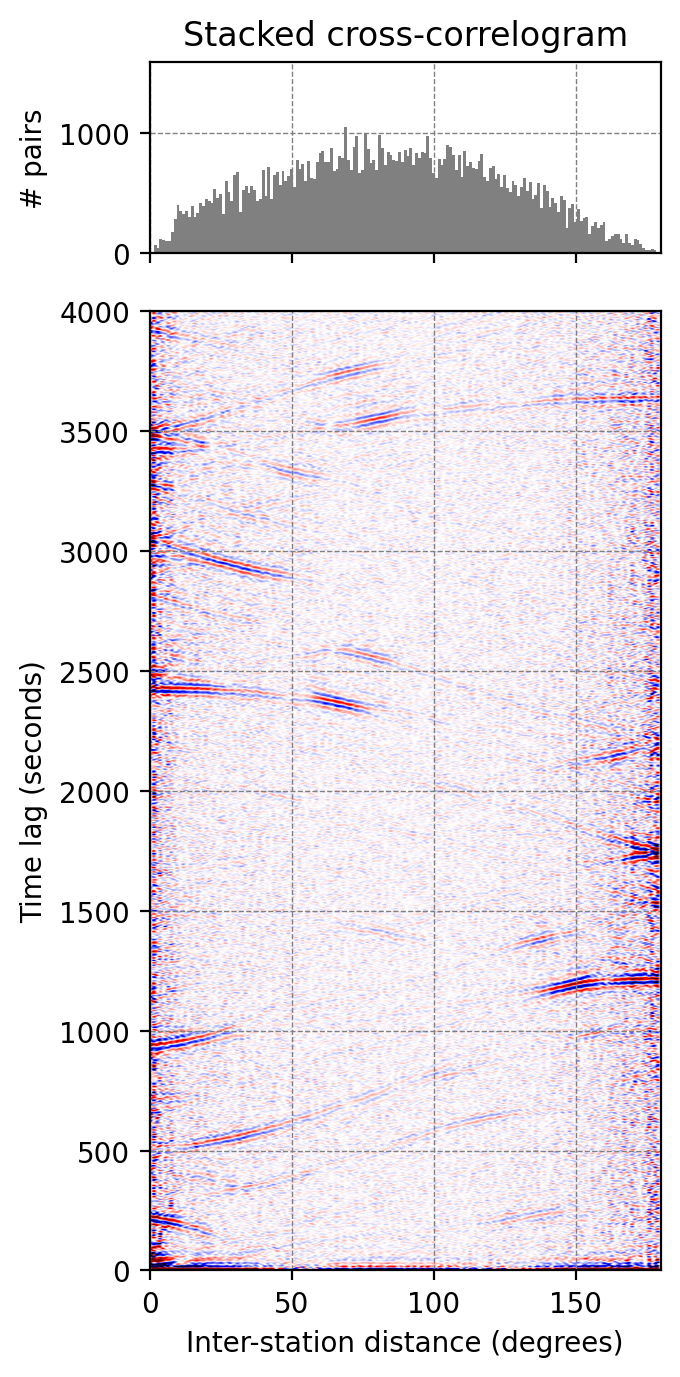

In [ ]:
#@title Plot the stacked cross-correlogram
#@markdown This cell with will stack all the submited correlogram and display the result.

def stack_correlograms(fname_list):
    """
    Stack the cross-correlograms from the given list of files.
    """
    # load the correlograms
    correlograms = [pickle.load(open(fname, 'rb')) for fname in fname_list]
    # get the number of bins and time lags
    bin_count = np.sum([c['bin_count'] for c in correlograms], axis=0)
    correlogram = np.sum([c['correlogram'] for c in correlograms], axis=0)

    output = correlograms[0].copy()
    output['bin_count'] = bin_count
    output['correlogram'] = correlogram
    return output

try:
    fname_list = [str(fname) for fname in Path('/content/drive/Othercomputers/My MacBook Pro/HUS_Workshop/ObsSeisHUS2025/Day4/XCORR').glob('*.npy')]
except ImportError:
    fname_list = [str(fname) for fname in Path('XCORR').glob('*.npy')]

plot_correlogram(stack_correlograms(fname_list), filter_kw, title='Stacked cross-correlogram')

---
## Conclusions
- The data processing presented in this notebook turns noisy data into valuable insights into the Earth's deep interior.
- This framework has enabled several discoveries of the deep Earth and planetary interiors at the ANU Global seismology group.

Please cite at least of one of the following article if you use a part or entire code in your research:
- H. Tkalčić, T.-S. Phạm and S. Wang, The Earth's coda correlation wavefield: Rise of the new paradigm and recent advances, Earth-Science Reviews, 208, doi:10.1016/j.earscirev.2020.103285, 2020.

- Phạm T.-S., H. Tkalčić, M. Sambridge, and B. L. N. Kennett, Earth's correlation wavefield: Late coda correlation, Geophys. Res. Lett., 45 (7),  doi:10.1002/2018GL077244, 2018.

- Tkalčić, H. and T.-S. Phạm, Shear properties of the Earth's inner core revealed by a detection of J waves in global correlation wavefield, Science, 362, doi:10.1126/science.aau7649, 2018.

